# AIMET dependencies install & build
The following group of cells installs the AIMET library for you. For more details, please see [this link](https://github.com/quic/aimet/blob/develop/packaging/google_colab_install.md).

You can clone this notebook and use it in your own project. Make sure that before running these cells, you connect to a hosted environment with a GPU accelerator. (Runtime -> Change runtime -> Hardware Accelerator(GPU))

## Installing dependencies
May prompt you.

!pip3 uninstall --yes protobuf
!pip3 uninstall --yes tensorflow
!apt-get update
!apt-get install python3.6
!apt-get install python3-dev
!apt-get install python3-pip
!apt-get install liblapacke liblapacke-dev
!apt-get install wget
!pip3 install numpy==1.16.4
!apt-get install libgtest-dev build-essential cmake
!pip3 --no-cache-dir install opencv-python==4.1.0.25
!pip3 --no-cache-dir install pillow==6.2.1
!pip3 install pytorch-ignite==0.1.0
!wget -q https://github.com/Itseez/opencv/archive/3.1.0.tar.gz -O /tmp/3.1.0.tar.gz > /dev/null
!tar -C /tmp -xvf /tmp/3.1.0.tar.gz > /dev/null
%cd /tmp/opencv-3.1.0
%mkdir release
%cd release
!cmake -DCMAKE_POSITION_INDEPENDENT_CODE=ON -DBUILD_SHARED_LIBS=OFF -DCMAKE_BUILD_TYPE=release -DWITH_FFMPEG=OFF -DBUILD_TESTS=OFF -DWITH_CUDA=OFF -DBUILD_PERF_TESTS=OFF -DWITH_IPP=OFF -DENABLE_PRECOMPILED_HEADERS=OFF .. > /dev/null
!make -j16 > /dev/null
!make -j16 install > /dev/null
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
!apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!dpkg -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
!apt-get update
!wget http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
!apt install ./nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
!apt-get update
!apt install cuda-cublas-10-0 cuda-cufft-10-0 cuda-curand-10-0 cuda-cusolver-10-0
!apt-get update && apt install cuda-cusparse-10-0 libcudnn7=7.6.2.24-1+cuda10.0 libnccl2=2.4.8-1+cuda10.0  cuda-command-line-tools-10.0
!pip3 install scipy==1.1.0
!pip3 install protobuf==3.7.1
!pip3 install scikit-learn==0.19.1
!pip3 install tb-nightly==1.14.0a20190517
!pip3 install tensorboardX==1.7
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.4.0%2Bcu100-cp36-cp36m-linux_x86_64.whl
!pip3 install https://download.pytorch.org/whl/cu100/torchvision-0.5.0%2Bcu100-cp36-cp36m-linux_x86_64.whl
!pip3 install --upgrade pip
!pip3 install tensorflow-gpu==1.15.0
!pip3 install future==0.17.1
!pip3 install tensorboard==1.14
!pip3 install bokeh==1.2.0
!pip3 install pandas==0.22.0
!pip3 install holoviews==1.12.7
!pip3 install --no-deps bokeh==1.2.0 hvplot==0.4.0
!pip3 install jsonschema==3.1.1
!pip3 install osqp onnx

!ln -s /usr/local/cuda-10.0 /usr/local/cuda
!apt-get update && apt-get install -y libjpeg8-dev
!ln -s /usr/lib/x86_64-linux-gnu/libjpeg.so /usr/lib

!apt install zlib1g-dev

!pip3 uninstall --yes Pillow && pip3 install Pillow-SIMD==6.0.0.post0
!pip3 uninstall --yes pytest
!pip3 install pytest

!pip3 install setuptools==41.0.1
!pip3 install keras==2.2.4

%rm -rf /usr/local/bin/python
!ln -s /usr/bin/python3 /usr/local/bin/python

After installing the dependencies, you must restart the environment before proceeding if you are working on google colab. (Runtime -> Restart Runtime) Don't run the first cell again in the restarted runtime.


## AIMET build and installation.

%cd /content/
!rm -rf aimet_code
!mkdir aimet_code
%cd aimet_code
!git clone https://github.com/quic/aimet.git
%cd aimet
%mkdir -p ./ThirdParty/googletest
%pushd ./ThirdParty/googletest
!git clone https://github.com/google/googletest.git -b release-1.8.0 googletest-release-1.8.0
%popd
%cd /content/aimet_code
%mkdir build
%cd build
!cmake -DCMAKE_EXPORT_COMPILE_COMMANDS=ON ../aimet
!make -j 8
!make install

## Setting up `PYTHONPATH` and `LD_LIBRARY_PATH`

import sys

sys.path.append(r'/content/aimet_code/build/staging/universal/lib/python')
sys.path.append(r'/content/aimet_code/build/staging/universal/lib/x86_64-linux-gnu')
sys.path.append(r'/usr/local/lib/python3.6/dist-packages')
sys.path.append(r'/content/aimet_code/build/artifacts')

import os

os.environ['LD_LIBRARY_PATH']+= ":/content/aimet_code/build/artifacts"

## Run unit tests
If the installation went smoothly, all tests should pass.

%cd /content/aimet_code/build/
!ctest

# Import necessary python packages

In [109]:
import os, sys
import warnings
from decimal import Decimal
import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager

import torchvision.transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from aimet_common.defs import CostMetric, CompressionScheme, GreedySelectionParameters
from aimet_torch.defs import ChannelPruningParameters, SpatialSvdParameters, ModuleCompRatioPair
from aimet_torch.compress import ModelCompressor
from aimet_torch.onnx_utils import OnnxSaver

from sklearn.metrics import f1_score
from torchvision.datasets import MNIST, CIFAR10
import timeit

# CIFAR models
from models import *

# Define a model and evaluation metrics

In [83]:
def get_test_loader(dataset):
    # Define test loader
    if dataset == "MNIST":
        transformImg = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                       torchvision.transforms.Normalize((0.1307,), (0.3081,))])


        test = MNIST(root='./data', train=False, download=True, transform=transformImg)
        test_loader = DataLoader(test, batch_size=1024, num_workers=4, shuffle=False, pin_memory=True)
        
    elif dataset == "CIFAR10":
        transformImg = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
        test = CIFAR10(root='./data', train=False, download=True, transform=transformImg)
        test_loader = DataLoader(test, batch_size=1024, num_workers=4, shuffle=False, pin_memory=True)
    
    else:
        print("Not a valid dataset, use 'MNIST' or 'CIFAR10.'")
        return
    
    return test_loader

In [84]:
test_loader = get_test_loader("CIFAR10")

Files already downloaded and verified


Set random seed for reprodubicility

In [85]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(33)

Define a model

In [86]:
class LeNet5(torch.nn.Module):          

    def __init__(self):     
        super(LeNet5, self).__init__()
        self.convs = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2),
                                    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2)
                                  )

        self.linears = nn.Sequential(nn.Linear(16*5*5, 120),
                                     nn.Linear(120, 84),
                                     nn.Linear(84, 10)
                                    )

    def forward(self, x):
        x = self.convs(x)
        x = x.flatten(start_dim=1)
        x = self.linears(x)

        return x

Define functions for conducting the training and testing epochs

In [140]:
def accuracy(out, y):
    preds = out.argmax(dim=1, keepdim=True).squeeze()
    correct = preds.eq(y).sum().item()
    return correct

def train_epoch(model, opt, train_loader, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    n_samples = 0
    for x, y in train_loader:
        opt.zero_grad()

        x, y = x.to(device), y.to(device)
        out = model.forward(x)
        loss = criterion(out, y)
        
        correct = accuracy(out, y)
        epoch_acc += correct
        epoch_loss += loss.item()
        n_samples += x.size(0)

        loss.backward()
        opt.step()
        
        total = y.size(0)


    epoch_acc = epoch_acc / n_samples
    epoch_loss = epoch_loss / n_samples

    return epoch_acc, epoch_loss

def test_epoch(model, test_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    n_samples = 0
    with torch.no_grad():
        for x,y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model.forward(x)
            loss = criterion(out, y)

            epoch_acc += accuracy(out, y)
            epoch_loss += loss.item()
            n_samples += x.size(0)

    epoch_acc = epoch_acc / n_samples
    epoch_loss = epoch_loss / n_samples

    return epoch_acc, epoch_loss

def display_grayscale(tensor):
    ''' show single tensor as grayscale image'''
    plt.imshow(tensor, cmap='gray')
    plt.show()

# Data processing

Define a class to apply imbalance to your datasets

In [131]:
class Dataset_Preprocessor:
    ''' class around MNIST object for applying imbalance to its dataset '''
    def __init__(self, dataset="MNIST"):
        
        # Convert imgs to tensor and normalize by mean and stddev of the training set
        if dataset == 'MNIST':
            transformImg = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))])


            self.dataset = MNIST(root='./data', train=True, download=True, transform=transformImg)

            
        elif dataset == "CIFAR10":
            transformImg = torchvision.transforms.Compose([
                torchvision.transforms.RandomCrop(32, padding=4),
                torchvision.transforms.RandomHorizontalFlip(),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])
            
            self.dataset = CIFAR10(root='./data', train=True, download=True, transform=transformImg)
            self.dataset.targets = torch.tensor(self.dataset.targets)
        
        else:
            print("Not a valid dataset, use 'MNIST' or 'CIFAR10.'")
            return
        
        self.class_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        self.selection_dict = dict()
        self.shuffle()
        self.dataloader = DataLoader(self.dataset, batch_size=128, num_workers=4, shuffle=True, pin_memory=True)
    
    
    
    def shuffle(self):
        ''' shuffle dataset '''
        # generate random ordered indeces for dataset
        datapoints = self.dataset.data.shape[0]
        rand_idx = torch.randperm(datapoints)

        # shuffle data and targets in the same way
        self.dataset.data = self.dataset.data[rand_idx]
        self.dataset.targets = self.dataset.targets[rand_idx]
    
    
    
    def keep_selection(self, target, selection):
        ''' create imbalance in single class of a dataset '''

        # get indices of imgs of target number and remove selection of the indices
        target_mask = self.dataset.targets == target
        selection_idx = target_mask.nonzero()[round(len(target_mask.nonzero())*selection):]

        # make mask wich selects all data except for indices in selection
        selection_mask = np.ones(len(self.dataset.data), dtype=bool)
        selection_mask[selection_idx] = False
        
        # apply mask to remove the selected data
        self.dataset.data = self.dataset.data[selection_mask]
        self.dataset.targets = self.dataset.targets[selection_mask]

    
    
    def apply_imbalance(self):
        ''' create imbalance in dataset according to selection dict '''

        # throw away a part of the data for each class
        for target, selection in self.selection_dict.items():
            self.keep_selection(target, selection)
        
        self.dataloader = DataLoader(self.dataset, batch_size=128, num_workers=4, shuffle=True, pin_memory=True)
        self.wrs_dataloader = self.apply_weighted_random_sampler()
        
        
    def balance(self):
        self.selection_dict = dict()
        self.apply_imbalance()
        return self.selection_dict
        
        
        
    def linear_imbalance(self, rho, apply=True):
        ''' create selection dict with linear imbalance '''
        
        min_examples = 1 / rho
        
        n_steps = len(self.class_order) - 1
        linear_step = (1.0 - min_examples) / n_steps

        # interpolate the classes between the minimum and maximum linearly
        for i, data_class in enumerate(reversed(self.class_order)):
            self.selection_dict[data_class] = min_examples + (i * linear_step)
        
        if apply:
            self.apply_imbalance()

        return self.selection_dict

            
            
    def step_imbalance(self, rho, mu, apply=True):
        ''' create selection dict with step imbalance '''
        
        min_examples = 1 / rho
        
        
        n_classes = len(self.class_order)
        step_index = int(mu * n_classes)

        for i, data_class in enumerate(reversed(self.class_order)):
            if i < step_index:
                self.selection_dict[data_class] = min_examples
            else:
                self.selection_dict[data_class] = 1.0

        if apply:
            self.apply_imbalance()
            
        return self.selection_dict


                  
    def long_tailed_imbalance(self, ratio, apply=True):
        ''' create selection dict with long-tailed imbalance '''
        
        # determine mu from ratio
        mu = (1/ratio)**(1/(len(self.class_order) - 1))
        
        # set selection for each class according to long-tailed function, mu is in (0,1)
        for i, data_class in enumerate(self.class_order):
            self.selection_dict[data_class] = mu**i

        if apply:
            self.apply_imbalance()
        
        return self.selection_dict
    
    
    
    def apply_weighted_random_sampler(self):
        ''' 
        return dataloader using weighted random sampling
        modified from https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264 
        by user ptrblck
        '''
        
        # get sample count per class
        class_sample_count = np.unique(self.dataset.targets, return_counts=True)[1]
        
        weight = 1. / class_sample_count
        
        # define weight per sample
        samples_weight = weight[self.dataset.targets]
        samples_weight = torch.from_numpy(samples_weight)
        
        sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
        
        # define weight usable for loss functions
        self.weight = torch.FloatTensor(weight / weight.sum())
        
        return DataLoader(self.dataset, batch_size=128, num_workers=4, pin_memory=True, sampler=sampler)
    
    
    
    def plot(self, title, color='r'):
        ''' plot the imbalance created by an imbalance function '''
        
        plt.bar(self.selection_dict.keys(), self.selection_dict.values(), color=color)
        plt.title(title)
        plt.show()

# Model training

Functions for training models

In [143]:
# Focal Loss function taken from https://github.com/gokulprasadthekkel/pytorch-multi-class-focal-loss
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__(weight, reduction=reduction)
        self.gamma = gamma
        self.weight = weight # weight parameter will act as the alpha parameter to balance class weights
        self.reduction = reduction
        
    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target,reduction=self.reduction, weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss


    
def train_model(train_loader, description="", model=LeNet5(), loss_func="CE", weight=None, gamma=2, 
                test=False, test_loader=test_loader, log=False):
    ''' train on data loader, and return trained model '''
    
    # Determine loss function
    if loss_func == "CE":
        criterion = nn.CrossEntropyLoss(weight=weight)
    elif loss_func == "FL":
        FL = FocalLoss(weight=weight, gamma=gamma)
        criterion = FL.forward
    else:
        print("That is not a valid loss function.")
        return
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    n_epochs = 10
    if log:
        writer = SummaryWriter(f'runs/{description}')
        
    model = model.to(device)
    opt = optim.SGD(model.parameters(), lr=1e-2)

    # Train+test, log to tensorboard
    # It's recommended to also print all the scalar values
    for i in range(n_epochs):
        sys.stdout.write(f"\repoch {i + 1}/{n_epochs}")
        sys.stdout.flush()
        train_acc, train_loss = train_epoch(model, opt, train_loader, criterion, device)
        
        if log:
            writer.add_scalar('train/acc', train_acc, i+1)
            writer.add_scalar('train/loss', train_loss, i+1)
        
        if test:
            test_acc, test_loss = test_epoch(model, test_loader, criterion, device)
            
            if log:
                writer.add_scalar('test/acc', test_acc, i+1)
                writer.add_scalar('test/loss', test_loss, i+1)
            
        
        
    return model

In [144]:
train = Dataset_Preprocessor()
train.long_tailed_imbalance(100)
train_loader = train.dataloader
model = train_model(train_loader)

epoch 10/10

# Model Compression
Using Channel Pruning and Spatial SVD

In [75]:
# Model compressor needs an evaluation function with this specific signature
def eval_callback(model, iterations, use_cuda=True):
    model.eval()
    epoch_acc = 0
    n_samples = 0
    with torch.no_grad():
        for idx,(x,y) in enumerate(test_loader):
            if use_cuda:
                device = 'cuda' if torch.cuda.is_available() else 'cpu'
                x, y = x.to(device), y.to(device)

            out = model.forward(x)
            epoch_acc += accuracy(out, y)
            n_samples += x.size(0)

            if iterations is not None:
                if idx == iterations:
                    break
        epoch_acc = epoch_acc / n_samples

    return epoch_acc

Define model compression

In [76]:
def compress_auto(model, comp_ratio, method, cost="mac", data=None, input_shape=(1, 1, 28, 28)):
    """
    Compresses a trained model to a certain ratio. Uses the user specified
    compression method. There are two options: "svd" or "prun".
    If using "prun" method, user needs to provide data.
    Returns the compressed model and a list containing:
    1. baseline_model_accuracy,
    2. compressed_model_accuracy,
    3. mac_compression_ratio, 
    4. memory_compression_ratio.
    """
    greedy_params = GreedySelectionParameters(target_comp_ratio=Decimal(comp_ratio))
    
    if cost == "mac": 
        cost_metric = CostMetric.mac
    elif cost == "memory":
        cost_metric = CostMetric.memory
    else:
        print("Unvalid cost metric, try again.")
        return
    
    if method == "svd":      
        auto_params = SpatialSvdParameters.AutoModeParams(greedy_params, [])
        spatial_svd_params = SpatialSvdParameters(mode=SpatialSvdParameters.Mode.auto,
                                                              params=auto_params)
        compress_scheme = CompressionScheme.spatial_svd
        compress_params = spatial_svd_params
 
    elif method == "prun":
        if data is None:
            print('Must provide data loader when using "prun"')
            return
        
        # Exclude first layer from pruning
        modules_to_ignore = [model.convs[0]]
        auto_params = ChannelPruningParameters.AutoModeParams(greedy_params, modules_to_ignore)
        channel_pruning_parameters = ChannelPruningParameters(mode=ChannelPruningParameters.Mode.auto,
                                                              params=auto_params,
                                                              data_loader=train_loader,
                                                              num_reconstruction_samples=1024,
                                                              allow_custom_downsample_ops=False
                                                              )
        compress_scheme = CompressionScheme.channel_pruning
        compress_params = channel_pruning_parameters
    
    else:
        print("Unknown method")
        return

    comp_model, stats = ModelCompressor.compress_model(model,
                                                        input_shape=input_shape,
                                                        eval_callback=eval_callback,
                                                        eval_iterations=None,
                                                        compress_scheme=compress_scheme,
                                                        cost_metric=cost_metric,
                                                        parameters=compress_params
                                                        )
    compare_mod = [stats.mac_compression_ratio, 
                   stats.memory_compression_ratio]
    
    return comp_model, compare_mod



def compress_manual(model, comp_ratio, method, cost="mac", data=None, input_shape=(1, 1, 28, 28)):
    """
    Compresses a trained model to a certain ratio. Uses the user specified
    compression method. There are two options: "svd" or "prun".
    If using "prun" method, user needs to provide data.
    Returns the compressed model and a list containing:
    1. baseline_model_accuracy,
    2. compressed_model_accuracy,
    3. mac_compression_ratio, 
    4. memory_compression_ratio.
    """   
    if cost == "mac": 
        cost_metric = CostMetric.mac
    elif cost == "memory":
        cost_metric = CostMetric.memory
    else:
        print("Unvalid cost metric, try again.")
        return

    if method == "svd":      
        manual_params = SpatialSvdParameters.ManualModeParams([ModuleCompRatioPair(model.convs[0], comp_ratio),
                                                              ModuleCompRatioPair(model.convs[3], comp_ratio)])
        spatial_svd_params = SpatialSvdParameters(mode=SpatialSvdParameters.Mode.manual,
                                                  params=manual_params)
        compress_scheme = CompressionScheme.spatial_svd
        compress_params = spatial_svd_params
 
    elif method == "prun":
        if data is None:
            print('Must provide data loader when using "prun"')
            return
        
        manual_params = ChannelPruningParameters.ManualModeParams([ModuleCompRatioPair(model.convs[3], comp_ratio)])
        channel_pruning_parameters = ChannelPruningParameters(mode=ChannelPruningParameters.Mode.manual,
                                                      params=manual_params,
                                                      data_loader=train_loader,
                                                      num_reconstruction_samples=1024,
                                                      allow_custom_downsample_ops=False
                                                      )
        compress_scheme = CompressionScheme.channel_pruning
        compress_params = channel_pruning_parameters
    
    else:
        print("Unknown method")
        return


    comp_model, stats = ModelCompressor.compress_model(model,
                                                        input_shape=input_shape,
                                                        eval_callback=eval_callback,
                                                        eval_iterations=None,
                                                        compress_scheme=compress_scheme,
                                                        cost_metric=cost_metric,
                                                        parameters=compress_params
                                                        )
    compare_mod = [stats.mac_compression_ratio, 
                   stats.memory_compression_ratio]
    
    return comp_model, compare_mod

Define F1-score function

In [77]:
def model_f1_score(model, test_loader):
    ''' compute the F1 score of a model on a test dataloader '''
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    y_pred = []
    y_true = []
    with torch.no_grad():
        for x,y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model.forward(x)
            preds = out.argmax(dim=1, keepdim=True).squeeze()
            y_pred += preds.squeeze().tolist()
            y_true += y.squeeze().tolist()
    return f1_score(y_true, y_pred, average='weighted')

Opening a tensorboard

In [78]:
%reload_ext tensorboard
!pip3 install tensorboard-plugin-wit
%tensorboard --logdir ./runs 

You are using pip version 9.0.1, however version 20.3.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Reusing TensorBoard on port 6006 (pid 10813), started 2 days, 5:07:48 ago. (Use '!kill 10813' to kill it.)

### Research Question 1
Using a compression ratio of 0.5 on both channel pruning and spatial SVD.
Long-tail imbalanced is used with a ratio of 10 (most frequent class appears 10 times more often than least frequent class).

In [79]:
# Define the dataloader
train_bal = Dataset_Preprocessor()
train_loader = train_bal.dataloader
train_imbal = Dataset_Preprocessor()
train_imbal.long_tailed_imbalance(10)
train_imbal_loader = train_imbal.dataloader

model_bal = train_model(train_loader, "Balanced")
model_imbal = train_model(train_imbal_loader, "Imbalanced")

f1_bal = model_f1_score(model_bal, test_loader)
f1_imbal = model_f1_score(model_imbal, test_loader)

In [ ]:
comp_model_bal_svd, stats_bal = compress_manual(model_bal, 0.5, "svd", cost="memory")
comp_model_imbal_svd, stats_imbal = compress_manual(model_imbal, 0.5, "svd", cost="memory")

2021-01-18 22:35:45,522 - Svd - INFO - Spatial SVD splitting layer: convs.0 using rank: 2
2021-01-18 22:35:45,529 - Svd - INFO - Spatial SVD splitting layer: convs.3 using rank: 10
2021-01-18 22:36:01,189 - Svd - INFO - Spatial SVD splitting layer: convs.0 using rank: 2
2021-01-18 22:36:01,202 - Svd - INFO - Spatial SVD splitting layer: convs.3 using rank: 10


In [14]:
%timeit acc_full = eval_callback(model_bal, None, use_cuda=True)
%timeit acc_comp = eval_callback(comp_model_bal_svd, None, use_cuda=True)

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

Test F1-score of compressed model.

In [ ]:
f1_bal_svd = model_f1_score(comp_model_bal_svd, test_loader)
f1_imbal_svd = model_f1_score(comp_model_imbal_svd, test_loader)

Test accuracy between balanced and imbalanced models

In [ ]:
# SVD RESULTS
# RATIO OF COMPRESSION IS 0.5
# RATIO OF IMBALANCE IS 10
print("------------------------BALANCED------------------------")
print(f"F1-score balanced model: {f1_bal}")
print(f"F1-score balanced compressed model: {f1_bal_svd}")
print("------------------------IMBALANCED------------------------")
print(f"F1-score imbalanced model: {f1_imbal}")
print(f"F1-score imbalanced compressed model: {f1_imbal_svd}")

------------------------BALANCED------------------------
F1-score balanced model: 0.8885108806913208
F1-score balanced compressed model: 0.8823908045738537
------------------------IMBALANCED------------------------
F1-score imbalanced model: 0.8254780312496826
F1-score imbalanced compressed model: 0.8298498812954888


In [ ]:
comp_model_bal_prun, stats_bal = compress_manual(model_bal, 0.5, "prun", cost="memory", data=train_imbal_loader)
comp_model_imbal_prun, stats_imbal = compress_manual(model_imbal, 0.5, "prun", cost="memory", data=train_imbal_loader)

f1_bal_prun = model_f1_score(comp_model_bal_prun, test_loader)
f1_imbal_prun = model_f1_score(comp_model_imbal_prun, test_loader)

2021-01-18 19:49:44,006 - ConnectedGraph - WARNING - Ops with missing modules: ['flatten_6']
This can be due to several reasons:
1. There is no mapping for the op in ConnectedGraph.op_type_map. Add a mapping for ConnectedGraph to recognize and be able to map the op.
2. The op is defined as a functional in the forward function, instead of as a class module. Redefine the op as a class module if possible. Else, check 3.
3. This op is one that cannot be defined as a class module, but has not been added to ConnectedGraph.functional_ops. Add to continue.


/workspace/build/staging/universal/lib/python/aimet_torch/winnow/winnow_utils.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(tensor)  # pylint: disable=not-callable


2021-01-18 19:49:46,106 - ChannelPruning - INFO - finished linear regression fit 
2021-01-18 19:49:49,263 - ConnectedGraph - WARNING - Ops with missing modules: ['flatten_6']
This can be due to several reasons:
1. There is no mapping for the op in ConnectedGraph.op_type_map. Add a mapping for ConnectedGraph to recognize and be able to map the op.
2. The op is defined as a functional in the forward function, instead of as a class module. Redefine the op as a class module if possible. Else, check 3.
3. This op is one that cannot be defined as a class module, but has not been added to ConnectedGraph.functional_ops. Add to continue.
2021-01-18 19:49:51,153 - ChannelPruning - INFO - finished linear regression fit 


/workspace/build/staging/universal/lib/python/aimet_torch/winnow/winnow_utils.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(tensor)  # pylint: disable=not-callable


2021-01-18 22:41:30,708 - ChannelPruning - INFO - finished linear regression fit 


In [ ]:
# PRUNING RESULTS
# RATIO OF COMPRESSION IS 0.5
# RATIO OF IMBALANCE IS 10
print("------------------------BALANCED------------------------")
print(f"F1-score balanced model: {f1_bal}")
print(f"F1-score balanced compressed model: {f1_bal_prun}")
print("------------------------IMBALANCED------------------------")
print(f"F1-score imbalanced model: {f1_imbal}")
print(f"F1-score imbalanced compressed model: {f1_imbal_prun}")

------------------------BALANCED------------------------
F1-score balanced model: 0.8885108806913208
F1-score balanced compressed model: 0.8865969683708745
------------------------IMBALANCED------------------------
F1-score imbalanced model: 0.8254780312496826
F1-score imbalanced compressed model: 0.8256167108489281


In [24]:
print(comp_model_bal_svd)

LeNet5(
  (convs): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 1, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0), bias=False)
      (1): Conv2d(1, 6, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    )
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linears): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)


## Testin imbalance learning methods
HEELLL yea (temporary)

In [ ]:
# Define test loader
transformImg = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])


test = MNIST(root='./data', train=False, download=True, transform=transformImg)
test_loader = DataLoader(test, batch_size=1024, num_workers=4, shuffle=False, pin_memory=True)

# Define train loaders
train = Dataset_Preprocessor()
train.long_tailed_imbalance(100) 
train_loader = train.dataloader
train_wrs_loader = train.wrs_dataloader
train_weight = train.weight #.cuda()

print(train_weight)

In [ ]:
# normal_imb_model = train_model(train_loader, "Long-Tailed")
# wrs_CE_model = train_model(train_wrs_loader, "Long-Tailed, WRS")
# normal_WCE_model = train_model(train_loader, "Weighted CE", weight=train_weight)
# wrs_WCE_model = train_model(train_wrs_loader, "WRS, Weighted CE", weight=train_weight)

models = []
model = train_model(train_loader, "Bug Fixing")

models.append(compress(model, 0.5, 'svd')[0])
models.append(compress(model, 0.3, 'svd')[0])
models.append(compress(model, 0.2, 'svd')[0])
models.append(compress(model, 0.1, 'svd')[0])

models.append(compress(model, 0.2, 'prun')[0])

# gamma_half = train_model(train_loader, "Focal Loss", loss_func="FL", weight=train_weight, gamma=0.19)
# gamma_one = train_model(train_loader, "Focal Loss", loss_func="FL", weight=train_weight, gamma=0.15)

# gamma_one_half = train_model(train_loader, "Focal Loss", loss_func="FL", weight=train_weight, gamma=0.25)
# gamma_two = train_model(train_wrs_loader, "WRS, Focal Loss", loss_func="FL", weight=train_weight, gamma=0.21)


# print("Gamma: 0.4 ;", our_f1_score(gamma_half, test_loader))
# print("Gamma: 0.3 ;", our_f1_score(gamma_one, test_loader))
# print("Gamma: 0.2 ;", our_f1_score(gamma_one_half, test_loader))
# print("Gamma: 0.1 ;", our_f1_score(gamma_two, test_loader))

# print("Just Imbalance:", our_f1_score(normal_imb_model, test_loader))
# print("WRS, normal CE:", our_f1_score(wrs_CE_model, test_loader))
# print("Normal loader, WCE:", our_f1_score(normal_WCE_model, test_loader))
# print("WRS, WCE:", our_f1_score(wrs_WCE_model, test_loader))
# print("Normal Loader, FL:", our_f1_score(normal_FL_model, test_loader))
# print("WRS, FL:", our_f1_score(wrs_FL_model, test_loader))

# out:
# Just Imbalance: 0.9464903384582831

# WRS, normal CE: 0.9533586754650354
# Normal loader, WCE: 0.9595584417399692
# WRS, WCE: 0.897340612775242
# Normal Loader, FL: 0.9251946954174868
# WRS, FL: 0.9048888067949405
# Normal Loader, FL (gamma=3): 0.8874900486210671
# WRS, FL (gamma=1): 0.9412699364062872
# Normal Loader, FL (gamma=1): 0.9519792810834111
# WRS, FL (gamma=3): 0.8853290644996112

# Gamma: 0.5 ; 0.9520905676432927
# Gamma: 1.0 ; 0.9489965087640392
# Gamma: 1.5 ; 0.9320343237494246
# Gamma: 2.0 ; 0.8816604889961507
# Gamma: 0.4 ; 0.9521100294383325
# Gamma: 0.3 ; 0.9553254760710955
# Gamma: 0.2 ; 0.9622722563627012
# Gamma: 0.1 ; 0.9546977824804741

In [ ]:


for model in models:
    print(model)

## Test 2
Varying the long-tailed imbalance but keeping the compress ratio constant.

In [ ]:
def imbal_ratio_tester(ratio_compr=0.5, method="manual", cost="mac", seeds=[42]):
    ''' test how different compression ratios behave under various imbalance ratios '''
    imb_ratios = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    # test the same model for multiple seeds
    for seed in seeds:
        f1_ogs = []
        f1_svds = []
        svd_times = []
        f1_pruns = []
        prun_times = []
        set_seed(seed)
        print(f"-----------------{seed}--------------")
        for ratio in imb_ratios:
            print(f"----------{ratio}--------------")
            # create dataloader
            train = Dataset_Preprocessor()
            train.long_tailed_imbalance(ratio)
            train_imbal_loader = train.dataloader

            # train model
            model_name = f"RQ2. Imbalance ratio: {ratio}, run: {seed}"
            model_imbal = train_model(train_imbal_loader, model_name)

            # compress model
            if method == "auto":
                comp_model_svd, stats_imbal_svd = compress_auto(model_imbal, ratio_compr, "svd", cost=cost)
                comp_model_prun, stats_imbal_prun = compress_auto(model_imbal, ratio_compr, "prun", cost=cost, data=train_imbal_loader)
            elif method == "manual":
                comp_model_svd, stats_imbal_svd = compress_manual(model_imbal, ratio_compr, "svd", cost=cost)
                comp_model_prun, stats_imbal_prun = compress_manual(model_imbal, ratio_compr, "prun", cost=cost, data=train_imbal_loader)
            else:
                print("Unvalid method, try again.")
                return
       
            # store F1-scores
            f1_ogs.append(model_f1_score(model_imbal, test_loader))
            
            f1_svds.append(model_f1_score(comp_model_svd, test_loader))
            
            f1_pruns.append(model_f1_score(comp_model_prun, test_loader))


        # print F1-scores in a table
        print(f"seed: {seed}")
        print("{:<25}|{:<25}|{:<25}|{:<25}".format("Imbalance", "F1 OG Model", "F1 SVD Model", "F1 PRUN Model"))
        for i in range(len(comp_ratios)):
            print("{:<25}|{:<25}|{:<25}".format(imb_ratios[i], f1_ogs[i], f1_svds[i], f1_pruns[i]))
       
    
    return f1_ogs, f1_svds, f1_pruns

warnings.filterwarnings("ignore")

In [ ]:
# MANUALLY CHOSEN COMPRESSION RATIO
# MAC COMPRESSION
imbal_ratio_tester(method="manual", seeds=[420, 893, 666])

In [ ]:
# MANUALLY CHOSEN COMPRESSION RATIO
# MEMORY COMPRESSION
imbal_ratio_tester(method="manual", cost="memory", seeds=[420, 893, 666])

In [ ]:
# AUTOMATIC CHOSEN COMPRESSION RATIO
# MAC COMPRESSION
imbal_ratio_tester(method="auto", seeds=[420, 893, 666])

In [ ]:
# AUTOMATIC CHOSEN COMPRESSION RATIO
# MEMORY COMPRESSION
imbal_ratio_tester(method="auto", cost="memory", seeds=[420, 893, 666])

## Test 3

Varying the compression ratio while keeping same inbalance

In [ ]:
def comp_ratio_tester(dataloader, loss_func='CE', description="", weight=None, gamma=1):
    comp_ratios = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    seeds = [31, 32, 33]
    f1_seeds = dict()
    for seed in seeds:
        set_seed(seed)
        f1_svds = []
        f1_pruns = []
        model = train_model(dataloader, description, weight=weight, loss_func=loss_func, gamma=gamma)
        for comp_ratio in comp_ratios:

            model_svd, stats_imbal_svd = compress(model, comp_ratio, "svd")
            model_prun, stats_imbal_prun = compress(model, comp_ratio, "prun", train_loader)

            f1_svds.append(model_f1_score(model_svd, test_loader))
            f1_pruns.append(model_f1_score(model_prun, test_loader))

        print(f"model {description}; seed: {seed}")
        print("{:<25}|{:<25}|{:<25}".format("Comp Ratio", "F1 SVD Model", "F1 PRUN Model"))
        for i in range(len(comp_ratios)):
            print("{:<25}|{:<25}|{:<25}".format(comp_ratios[i],f1_svds[i],f1_pruns[i]))
        
        f1_seeds[seed] = {'svd': f1_svds, 'prun': f1_pruns}
    return f1_seeds

warnings.filterwarnings("ignore")

comp_ratio_tester(train_loader, description="Baseline")
comp_ratio_tester(train_wrs_loader, description="WRS")
comp_ratio_tester(train_loader, description="WCE", weight=train_weight)
comp_ratio_tester(train_wrs_loader, description="WRS, Weighted CE", weight=train_weight)
comp_ratio_tester(train_loader, description="Focal Loss, gamma=1", loss_func="FL", weight=train_weight, gamma=1)


            OG                           SVD                          PRUN                    
           420       893       666       420       893       666       420       893       666
1     0.981793  0.976605  0.980471  0.973411  0.971827  0.974512  0.979393  0.976198  0.977867
50    0.855774  0.831923  0.837634  0.857461  0.830599  0.819689  0.849198  0.830776  0.835212
100   0.721746  0.732836  0.712516  0.716993  0.729102  0.706367  0.718848  0.730134  0.711002
200   0.645484  0.637173  0.658068  0.628906  0.636931  0.657147  0.644136  0.636058  0.656787
300   0.620102  0.597130  0.615278  0.618130  0.594412  0.616913  0.621294  0.598376  0.616556
400   0.592727  0.590458  0.599443  0.582644  0.581747  0.587252  0.591200  0.591849  0.598302
500   0.467602  0.560481  0.413342  0.471146  0.550743  0.384050  0.469093  0.559893  0.413173
600   0.458148  0.537751  0.528681  0.443136  0.554112  0.540063  0.457954  0.537730  0.527830
700   0.514948  0.466831  0.488399  0.498565  0.45

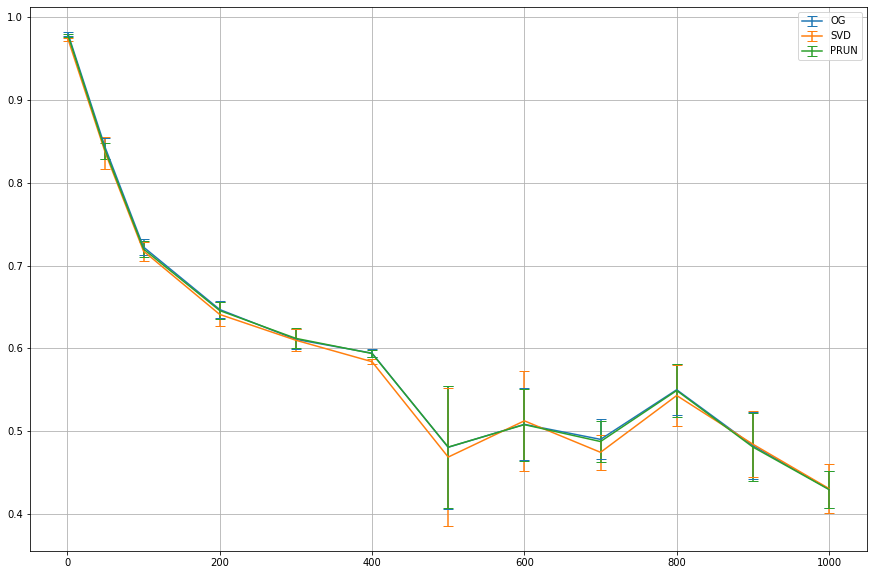

In [87]:
import pandas as pd

df_f1 = pd.read_csv('df_f1.csv', header=[0, 1], skipinitialspace=True, index_col=0)
df_time = pd.read_csv('df_time.csv', header=[0, 1], skipinitialspace=True, index_col=0)

df_f1.columns = pd.MultiIndex.from_tuples(df_f1.columns)
df_time.columns = pd.MultiIndex.from_tuples(df_f1.columns)
pd.set_option('expand_frame_repr', False)

models = ["OG", "SVD", "PRUN"]

cut_ratios = [1, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
df_f1 = df_f1.drop(index=[10, 20, 30, 40, 60, 70, 80, 90])

print(df_f1)
print(df_time)

tuples =[('OG', 420), ('OG', 893), ('OG', 666), ('SVD', 420), ('SVD', 893), ('SVD', 666), ('PRUN', 420), ('PRUN', 893), ('PRUN', 666)]

df_f1_mean = pd.DataFrame(index=cut_ratios, columns=tuples)
df_f1_std = pd.DataFrame(index=cut_ratios, columns=tuples)

plt.figure(figsize=(15,10))
# plt.xscale('log')
plt.grid()

for model in models:
    mean = df_f1[model].mean(axis=1)
    std = df_f1[model].std(axis=1)
    
    print(mean)
    df_f1_mean[model] = mean
    df_f1_std[model] = std
    plt.errorbar(cut_ratios, mean, yerr=[std, std], capsize=5, label=model)

plt.legend()
plt.show()